<a href="https://www.kaggle.com/code/anaskadi/3d-object-detection?scriptVersionId=181570301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This is certainly an interesting and challenging competition.
![gif](https://raw.githubusercontent.com/lyft/nuscenes-devkit/master/notebooks/media/001.gif)
Lets take a look at the 85GB unique dataset!



**Disclaimer: I do not know anything about 3D object detection nor about Autonomous Vehicles. 
The notebook is provided "as is", without warranty of any kind... :)**

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime as dt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import warnings

In [2]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 99
sns.set_palette(sns.color_palette('tab20', 20))

In [3]:
start = dt.datetime.now()

In [4]:
base = '/kaggle/input/3d-object-detection-for-autonomous-vehicles/'
dirs = os.listdir(base)
print(dirs)

['sample_submission.csv', 'train_images', 'test_data', 'test_maps', 'test_lidar', 'train.csv', 'train_lidar', 'train_data', 'train_maps', 'test_images']


# Unique ground truth and submission format
We are required to optimize a custom performance metric, the mean average precision[](http://) at different intersection over union (IoU) thresholds.

In [5]:
train = pd.read_csv(base + 'train.csv')
sample_submission = pd.read_csv(base + 'sample_submission.csv')
print(f'train: {train.shape}, sample submission: {sample_submission.shape}')
train.head(2)
sample_submission.head(2)

train: (22680, 2), sample submission: (27468, 2)


,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...


,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,NaN
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,NaN


The annotations in train.csv have the following components:
* **center_x**, **center_y** and **center_z** are the world coordinates of the center of the 3D bounding volume.
* **width**, **length** and **height** are the dimensions of the volume.
* **yaw** is the angle of the volume around the z axis (where y is forward/back, x is left/right, and z is up/down - making 'yaw' the direction the front of the vehicle / bounding box is pointing at while on the ground).
* **class_name** is the type of object contained by the bounding volume.


**We have 638K annotated objects in 22K train samples.**

In [6]:
# Let's check the parsing of prediction strings. Each object should have 8 params
max([len(ps.split(' ')) % 8 for ps in train.PredictionString.values])

0

In [7]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

100%|██████████| 22680/22680 [00:03<00:00, 6155.19it/s]


In [8]:
for col in object_columns[2:-1]:
    train_objects[col] = train_objects[col].astype('float')
train_objects['confidence'] = 1.0

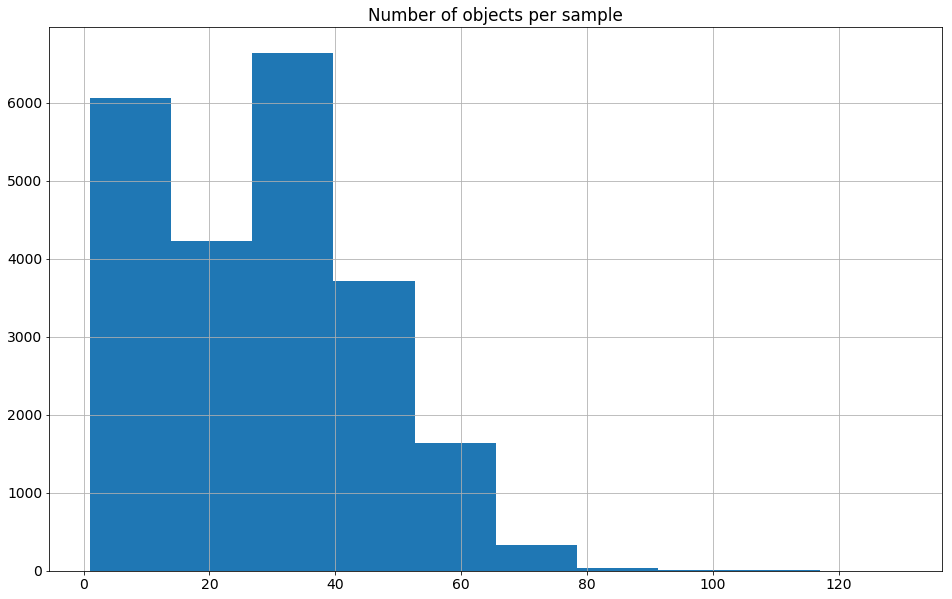

In [9]:
train_objects.groupby('sample_id').count()[['object_id']].hist()
plt.title('Number of objects per sample')
plt.show();

In [10]:
train_objects.shape
train_objects.head()
train_objects.describe()

(638179, 11)

,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name,confidence
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0,2680.283036,698.196929,-18.047767,2.064,5.488,2.053,2.604164,car,1.0
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1,2691.997462,660.801654,-18.674259,1.818,4.570,1.608,-0.335176,car,1.0
2,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2,2713.607501,694.403481,-18.589972,1.779,4.992,1.620,2.579456,car,1.0
3,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,3,2679.986917,706.910150,-18.349594,1.798,3.903,1.722,2.586166,car,1.0
4,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,4,2659.352096,719.417462,-18.442999,1.936,4.427,1.921,2.601799,car,1.0


,object_id,center_x,center_y,center_z,width,length,height,yaw,confidence
count,638179.000000,638179.000000,638179.000000,638179.000000,638179.000000,638179.000000,638179.000000,638179.000000,638179.0
mean,18.897229,1715.069665,1372.186384,-20.369027,1.915676,4.905273,1.851623,0.829982,1.0
std,14.524981,640.835671,560.929774,2.843186,0.461967,1.973170,0.536324,1.709260,0.0
min,0.000000,366.763064,309.814266,-24.985069,0.223000,0.261000,0.333000,-3.141549,1.0
25%,7.000000,1161.721817,926.375533,-22.694964,1.803000,4.423000,1.555000,-0.550722,1.0
50%,16.000000,1554.106494,1383.464471,-20.140146,1.901000,4.689000,1.705000,1.001660,1.0
75%,28.000000,2315.286364,1646.055137,-18.649414,2.049000,5.032000,1.894000,2.591989,1.0
max,129.000000,3205.812665,3642.478804,6.136931,4.157000,22.802000,8.862000,3.141446,1.0



### Object annotations

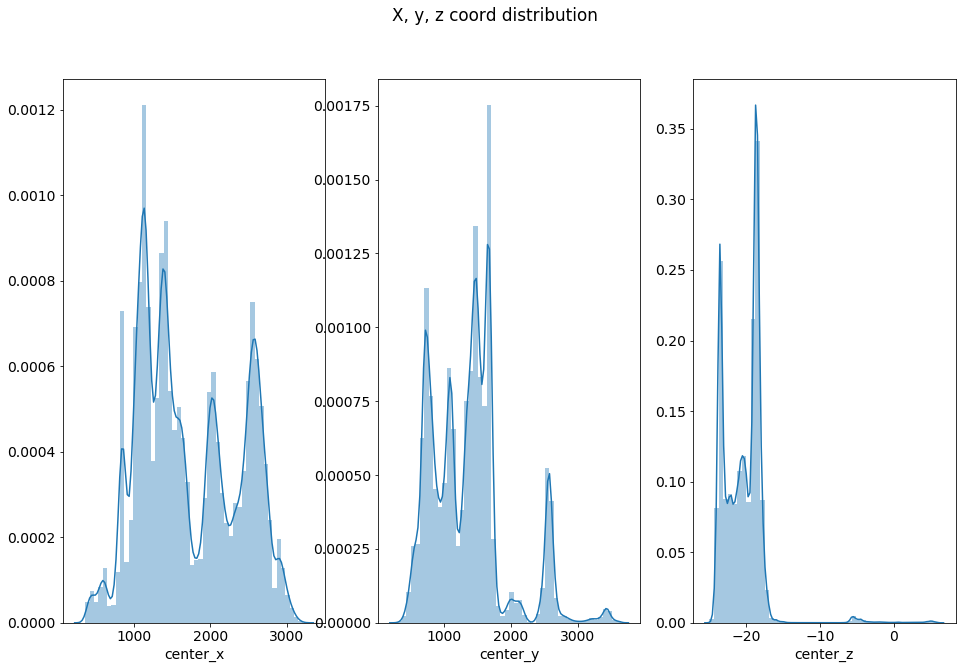

In [11]:
fig, ax = plt.subplots(ncols=3)
sns.distplot(train_objects.center_x, ax = ax[0])
sns.distplot(train_objects.center_y, ax = ax[1])
sns.distplot(train_objects.center_z, ax = ax[2])
plt.suptitle('X, y, z coord distribution')
plt.show();

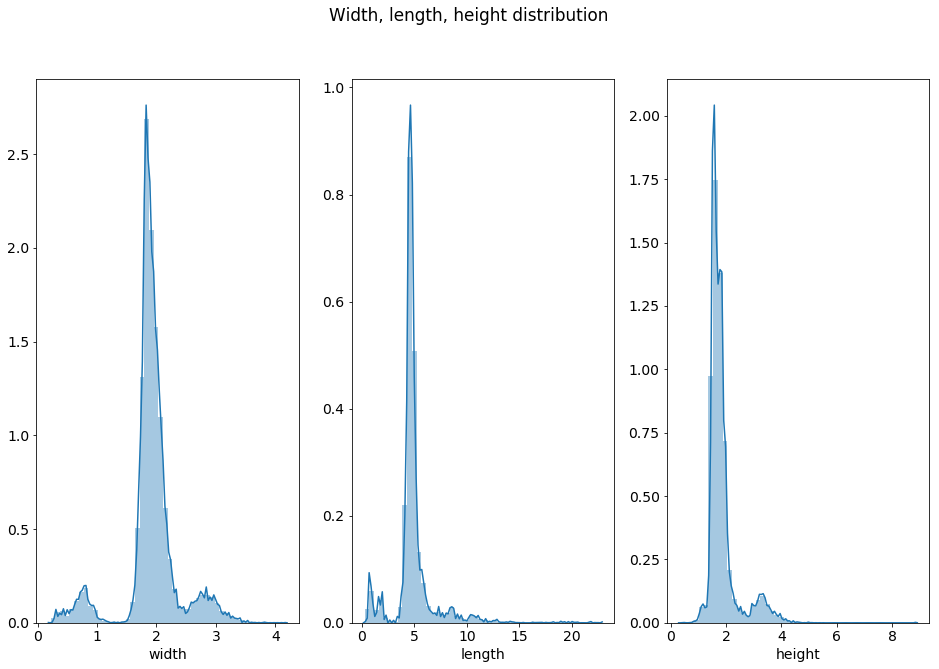

In [12]:
fig, ax = plt.subplots(ncols=3)
sns.distplot(train_objects.width, ax = ax[0])
sns.distplot(train_objects.length, ax = ax[1])
sns.distplot(train_objects.height, ax = ax[2])
plt.suptitle('Width, length, height distribution')
plt.show();

### Classes

Vast majority of the annotated objects is just car. We have other vehicles and pedestrians to detect.

In [13]:
class_cnt = train_objects.groupby('class_name').count()[['object_id']].sort_values(by='object_id', ascending=False).reset_index()
class_cnt['p'] = class_cnt.object_id / class_cnt.object_id.sum() 
class_cnt

,class_name,object_id,p
0,car,534911,0.838183
1,other_vehicle,33376,0.052299
2,pedestrian,24935,0.039072
3,bicycle,20928,0.032793
4,truck,14164,0.022194
5,bus,8729,0.013678
6,motorcycle,818,0.001282
7,animal,186,0.000291
8,emergency_vehicle,132,0.000207


In [14]:
train_objects.groupby('class_name').mean()

,object_id,center_x,center_y,center_z,width,length,height,yaw,confidence
class_name,,,,,,,,,
animal,17.145161,1442.769226,1546.551084,-21.815733,0.359349,0.731124,0.514984,0.381463,1.0
bicycle,22.337729,1340.481183,1674.183601,-21.516081,0.625311,1.763283,1.441450,0.874724,1.0
bus,17.227976,1995.313886,1204.659164,-18.537816,2.956546,12.341555,3.436880,1.303888,1.0
car,18.936965,1719.761630,1363.238092,-20.465983,1.925326,4.756200,1.718287,0.749766,1.0
emergency_vehicle,15.219697,1918.118924,1163.807229,-18.976714,2.447879,6.523545,2.393091,0.217813,1.0
motorcycle,17.514670,1665.896546,1399.646722,-20.387106,0.963260,2.352494,1.585488,0.667861,1.0
other_vehicle,18.226480,2069.187988,1102.505531,-18.753021,2.787712,8.197576,3.227663,2.394797,1.0
pedestrian,17.129938,1376.560910,1709.764255,-20.582075,0.772448,0.806256,1.775256,0.248543,1.0
truck,18.170714,1684.646325,1406.404298,-19.566985,2.844550,10.240012,3.436063,0.858457,1.0


# Sample submission

In [15]:
x, y, z, w, l, h, yaw = train_objects[[
    'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']].mean()
mean_prediction_string = ' '.join(map(str, [0.9, x, y, z, 10*w, 10*l, h, yaw, 'car']))


In [16]:
sample_submission['PredictionString'] = mean_prediction_string 
sample_submission.to_csv('submission.csv', index=False)

In [17]:
sample_submission.shape
sample_submission.head()

(27468, 2)

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,0.9 1715.069665099624 1372.186383587289 -20.36...
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,0.9 1715.069665099624 1372.186383587289 -20.36...
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,0.9 1715.069665099624 1372.186383587289 -20.36...
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,0.9 1715.069665099624 1372.186383587289 -20.36...
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,0.9 1715.069665099624 1372.186383587289 -20.36...


## Train data

In [18]:
for f in os.listdir(base + 'train_data'):
    print(f)
    try:
        df = pd.read_json(base + 'train_data/' + f)
        df.shape
        df.head()
        df.nunique()
    except Exception as e:
        print(e)

instance.json


(18421, 5)

,last_annotation_token,category_token,token,first_annotation_token,nbr_annotations
0,bcaa7c8be6503c2c2767b414e89598ea45ec1bf431eec1...,8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0...,c50ef1538e11e03d232eca295c80b0e76040507d4d2785...,9811e373205791873b2a6aeb7852392fd4e060ea00074d...,49
1,239d0037b395a24dc110529cbd4be98595d12cea75b396...,8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0...,a2629c325a79dce75fd81d84ef740f3ef2d5f1bce25e70...,8120e562b58cc2c7945b9490262f08b1645563565a4d61...,8
2,3c6fc88ad381df38877db77de1401d4cde2ac8ed1d8e88...,8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0...,570abc2fb67078ced6e96f7575c426db9128c98f05d161...,4e1e519ff84e06e10a2e5432e7fa645271de29b9649e9f...,8
3,6a8ae9350f035f919c5ca2e56f5f5146bbf11fc7cd2e33...,8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0...,13d1f3b371fee6e5d48caf485d6cd77ee596a74cb65c10...,b168495ce46746299d77892f89cdee90c9d60d6dec6ec5...,28
4,804c82796713e93b4d52f3aeffceafef11acd9df2e4183...,8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0...,2d385a1fd60f20328382dd7484072712a4af3c34b3b2b1...,35564902196445be52d2b95aafa1e41c77505199ec732f...,39


last_annotation_token     18421
category_token                9
token                     18421
first_annotation_token    18421
nbr_annotations             126
dtype: int64

scene.json


(180, 7)

,log_token,first_sample_token,name,description,last_sample_token,nbr_samples,token
0,da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e...,24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa...,host-a101-lidar0-1241893239199111666-124189326...,,2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e...,126,da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e...
1,0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3...,3b30673b9d944ec6058ef5a8debb4c0a6fe075bca7076e...,host-a006-lidar0-1236037883198113706-123603790...,,5ec01e4634ca91751311eaafb45a9196ba8616bf05edc8...,126,0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3...
2,a939e6edc494777d058c3b1eafb91a7236f6b4ff5e98c9...,fcad797faa988f50be306e5fb6971de295602ee9116bd9...,host-a011-lidar0-1235950297199142196-123595032...,,92690bc3dc7c90bd831146f8505c3b4b67603997d9df74...,126,a939e6edc494777d058c3b1eafb91a7236f6b4ff5e98c9...
3,e8f8379c823fd0505b63f2612505e1d3de1018ecc3328f...,8e1f13379721c1ab1d073607534ce7c195143cb8911715...,host-a012-lidar0-1235937130198577346-123593715...,,c9a3c20169f5ec811a81c3d12d55495ae4dc9b6f77403c...,126,e8f8379c823fd0505b63f2612505e1d3de1018ecc3328f...
4,ccc0662a4dbc63f589358ac9589b677f6d4165a128af93...,b6380a94d11315d22fd2313ae2e627ccb3579150cc9c67...,host-a101-lidar0-1240875136198305786-124087516...,,bb4297a8c979ee45eb8f33d682767347c385b6ed1dee2e...,126,ccc0662a4dbc63f589358ac9589b677f6d4165a128af93...


log_token             180
first_sample_token    180
name                  180
description             1
last_sample_token     180
nbr_samples             1
token                 180
dtype: int64

sample_data.json


(189504, 12)

,is_key_frame,prev,fileformat,token,timestamp,next,ego_pose_token,sample_token,filename,calibrated_sensor_token,width,height
0,True,d190078ec7869ad5c9e5417371aa3b45eb1c22804a0a29...,bin,ad87e1763749cc8562cca68e2046db128185c80c3e7599...,2019-02-11 21:36:23.701948250,8182fb6868baf63c245a4994b7f3034a7d281d1928a784...,d90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeae...,fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced3...,lidar/host-a007_lidar1_1233956183701948366.bin,3b463530b5bae9698c9cc803c1731c36abd359a7296e23...,NaN,NaN
1,True,83f6f61cb6f2fc9b985cc23bd5613219eee7da390cd083...,bin,ea079138d89f3887b2bfcddfe16b747e2ec7a366ce66b3...,2019-03-04 23:27:01.601281500,c291c5e9c1c70363496e304e964a33036cace6d14c177e...,97c348ec54ca0cfc892361595513d34d19e53583f97832...,c60dc70e93949cbefdda68813cf024fe8e9103bc8a68d6...,lidar/host-a008_lidar1_1235777221601281486.bin,2dba2d3171d7c60b847d65d96babfd7efb487428fa5a3c...,NaN,NaN
2,True,44555daed204fea486ec10ea1747432501b9f06fe93041...,jpeg,454c65ee6c297d64b17852b4c56def9781a84dcb8558a8...,2019-02-20 23:24:24.650905000,d4b751751ca5424375d0faf3d22b9af83e7c84e1598ba0...,dce9c81e168db4f6fa442cc0bd484a4926dfe73946ba59...,254cea140f7d14fc86e73f789794fb73f81c05831d40f3...,images/host-a007_cam6_1234740264650905006.jpeg,30fcfa36375c0d36fce508cd04c9b1dd07ac283eb87352...,2048.0,864.0
3,True,de75f3f347742035f2442f4a5fa0334946642daa2d07d8...,jpeg,779018e1f92debcf5c5c28e9577677c6595679780bdf9b...,2019-01-07 22:44:02.299360000,4796998aae092f295fe4f96ce57fc673e3292c7b0368ac...,bb93bbeb3b6d151c805729dba52d4c0c0070f20376090b...,810503d8ca51e9692021ecb56e2b2f2098beaf396cd207...,images/host-a007_cam3_1230936242299360006.jpeg,76e7bb72dd96cb18f5c75abae3b5bab5e41bd4aac39445...,1224.0,1024.0
4,True,a208568472ef6719faa2540622ada30b004583de9153f4...,jpeg,d966960819eb0aca2883cd3c8d8c5e2540bda952a8cada...,2019-02-08 18:20:23.917652000,1a82a24dafde93234579ae59f48498a8436361cc641a64...,53f6821330f6bc07603db70fde1a96b25bd919471e923c...,119b8c4bbaf1493bebaaa7d823934a8a3f5a80fb095630...,images/host-a004_cam2_1233685223917652006.jpeg,aac6241dd5e28264de261422696af2037868c5133d9329...,1224.0,1024.0


is_key_frame                    1
prev                       188001
fileformat                      2
token                      189504
timestamp                  179421
next                       188001
ego_pose_token             177789
sample_token                22680
filename                   189501
calibrated_sensor_token       148
width                           3
height                          3
dtype: int64

category.json


(9, 3)

,description,token,name
0,,8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0...,car
1,,73e8de69959eb9f5b4cd2859e74bec4b5491417336cad6...,pedestrian
2,,f81f51e1897311b55c0c6247c3db825466733e08df687c...,animal
3,,a8619a81f5acc7da2a2f034420db2b2f43a015c8c68982...,other_vehicle
4,,7ea5868735dc408109bfa74fd139bd8c5aa3767b52e054...,bus


description    1
token          9
name           9
dtype: int64

attribute.json


(18, 3)

,description,token,name
0,,f5081f1e5aa941f9d9f727ad186c8db67b916336f975a2...,object_action_lane_change_right
1,,1b388c1f5e5149ae173ad3d674e7ad7f1847e213173d14...,object_action_running
2,,17d61007ee69782e0ad8ffa5f8cd4c075f18b4b09e11f0...,object_action_lane_change_left
3,,5466ded30df08d7d825412ac907017d6ae00ff19051c63...,object_action_parked
4,,8b08df37edc70b7327d54b3fbf9e7e5894e1a31a93fe77...,object_action_standing


description     1
token          18
name           18
dtype: int64

map.json


(1, 4)

,log_tokens,token,filename,category
0,[da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952...,53992ee3023e5494b90c316c183be829,maps/map_raster_palo_alto.png,semantic_prior


("unhashable type: 'list'", 'occurred at index log_tokens')
sample.json


(22680, 5)

,next,prev,token,timestamp,scene_token
0,1d2350b3b20e3a5db2407e4075fc14f9f9ddfe0018f1da...,14511199ea101b40683cefafb9fcf5c2fb512fa500c3e6...,b98a05255ba2632e957884758cb31f0e6fcc8d3cd6ee76...,2019-03-08 22:21:26.901126000,18c6c670114eebd813ef240b05b988646bbccbbc5254df...
1,4f027d171715d57cd62079924e439f9ab17d228f27999a...,692caabc1f06aeda9f43d6252a070178430dec2158f19e...,78ce15b2b7360b8cd696d1097c60ec2184b69c17412564...,2019-05-14 17:21:54.702215250,8bc90aa0c14148c86d18c59cbe706a437d0710ed2dfb5e...
2,b66fb3c9a787cae35330b69f06cc18a7f06d0e61c7d06f...,0999dad89d3c95dd2976b4631b6deb3b3000e4de27afa3...,095d5bb88eb9cdd223b90d2a1475c0cf2f4b4c2a8aca82...,2019-01-29 16:41:09.301792500,328ee9d180f02a82516e8c5b4113ed18d8a36d2023c3ed...
3,063ea8386aa8156c1cd7c91bb1ac433f0b58d471e12658...,3222c742893edd007b982e9e7db40b7a598972d07bf759...,c2f0b2b2c0d576d42eab6e8703c4eacd302a79d4d702bd...,2019-02-06 19:22:54.901775500,3000622b0d524cddccec8df22e1613a9d821b26662a6f1...
4,163666a4128b13159abd8ba202d9f0b05229507c27fc6b...,,f59c9f22016b783c6a7e5225fc56fccaf4fe3df4a9d96c...,2019-01-29 22:53:32.300624750,b8492fd868445918e25be1f061e5c3488252b8c05a6775...


next           22501
prev           22501
token          22680
timestamp      22680
scene_token      180
dtype: int64

sample_annotation.json


(638179, 12)

,token,num_lidar_pts,size,sample_token,rotation,prev,translation,num_radar_pts,attribute_tokens,next,instance_token,visibility_token
0,92bff46db1dbfc9679edc8091770c4256ac3c027e9f0a9...,-1,"[2.064, 5.4879999999999995, 2.053]",db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,"[0.265491936795379, 0, 0, 0.964113080243515]",db2c5aea69d8be40a746c5f3df9366e030189b07647212...,"[2680.2830359778527, 698.1969292852777, -18.04...",0,[1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9...,33e07b849d62718279c9548fe662d32247e319f0451cd4...,abea2eb040d9c8fa1a44fa54020daaf9e2aa696e95e1d2...,
1,04c4c9883de582c5c4e7a45273a978a52b0432de18883f...,-1,"[1.635, 4.339, 1.5150000000000001]",edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,"[-0.960368393025626, 0, 0, 0.27873383303319205]",fadeb42661a9af6ff36d3ee60bb68b01a03c59e83bdcdc...,"[1208.642684768659, 1585.1812946970927, -23.56...",0,[7fc1ca3d36808cd1858e9c01ad4e7630ff3ca9e720065...,1b29baa915a0e1835b322e83efe0cfaa9b483fa96e1b34...,c3824f5ed11d382a4742d00a3a2e8deea4e6c21198151c...,
2,4226ce1636193ced735e21ff3c6dcc292415c72d0f84b4...,-1,"[1.963, 4.345, 1.749]",1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,"[-0.586906141065068, 0, 0, 0.8096549768760201]",bdcef23d3174acfd0383b2b8faba5b9e77ddbc2b7b6160...,"[848.9346793681768, 2587.2870557176507, -20.15...",0,[1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9...,ada6f7609e72098e2838ba44b03a4f15c2441e19e0c560...,0e6f00583ee6a407f7f48b52b60d3a6539caa7fdbab17c...,
3,f2446d4ca4b3e79e982cf0a4134af12e71e7b59df42f42...,-1,"[2.2, 5.39, 2.187]",a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,"[0.27359763662735503, 0, 0, 0.961844235431041]",d24fee88f5367f04f721041737dbcc497a3a3e4f9bc443...,"[1994.4320280494098, 1128.30164336183, -18.054...",0,[7fc1ca3d36808cd1858e9c01ad4e7630ff3ca9e720065...,de973be82ff2cc335bddcf27635c5d9e322a468a0d8dbd...,da82552a3b59ecd73d3c0be8aecec67296585f5c4b473e...,
4,1f5bdec4a1dff45dbbb4db094445dd4051eb39c9b4a2a3...,-1,"[1.837, 5.406, 1.721]",b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,"[0.12864510419303601, 0, 0, 0.991690696319756]",ed091f417281204c1dc2f08b497e6e013280be43373dc4...,"[1030.3877156973385, 1667.13131694941, -23.764...",0,[5466ded30df08d7d825412ac907017d6ae00ff19051c6...,5e189a3afd1a723013a90e547991204ea14220ce0912f0...,21919dfc393baac38a32abe7acc09fd0e1f6f6020dcf9b...,


("unhashable type: 'list'", 'occurred at index size')
sensor.json


(10, 3)

,modality,channel,token
0,camera,CAM_FRONT_LEFT,f7dad6bb70cb8e6245f96e5537e382848335872e6e2592...
1,lidar,LIDAR_FRONT_LEFT,629da739ea3a0814b9d79ffc3b99cdbc8bdbb6f97abf13...
2,camera,CAM_FRONT,eb9e8f60a3d6e3328d7512b9f8e6800127fe91f4d62bc8...
3,lidar,LIDAR_TOP,25bf751d7e35f295393d8a418731474b21c1f702e878c4...
4,camera,CAM_BACK_LEFT,c84592e22beb2c0f14d5159245ce8d6678431b879e940e...


modality     2
channel     10
token       10
dtype: int64

visibility.json


(4, 3)

,level,description,token
0,v60-80,visibility of whole object is between 60 and 80%,3
1,v0-40,visibility of whole object is between 0 and 40%,1
2,v40-60,visibility of whole object is between 40 and 60%,2
3,v80-100,visibility of whole object is between 80 and 100%,4


level          4
description    4
token          4
dtype: int64

log.json


(180, 5)

,date_captured,location,token,vehicle,logfile
0,2019-05-14,Palo Alto,da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e...,a101,
1,2019-03-07,Palo Alto,0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3...,a006,
2,2019-03-06,Palo Alto,a939e6edc494777d058c3b1eafb91a7236f6b4ff5e98c9...,a011,
3,2019-03-06,Palo Alto,e8f8379c823fd0505b63f2612505e1d3de1018ecc3328f...,a012,
4,2019-05-02,Palo Alto,ccc0662a4dbc63f589358ac9589b677f6d4165a128af93...,a101,


date_captured     43
location           1
token            180
vehicle           12
logfile            1
dtype: int64

ego_pose.json


(177789, 4)

,rotation,translation,token,timestamp
0,"[0.804543750284456, 0.024107923659982003, 0.01...","[622.726103039258, 3460.3733051620957, -6.8134...",2de7c52546f3f9bf6734084da8a2c1edaa0ffbea7f6e86...,2019-01-11 00:14:27.901671750
1,"[-0.59298986062737, -0.011481443936186001, 0.0...","[422.73128659665366, 2823.226294125566, -18.25...",b270648672b4995af5aa80e34c8150897b17c9b96dc6b8...,2019-01-28 17:41:10.401845000
2,"[0.27966860437301805, 0.002711555186854, 0.009...","[1112.137330836936, 1671.8727689601853, -24.53...",c85d360434ae69600fa5918da32375335b3b3571be7c2b...,2019-02-11 21:18:59.900980500
3,"[0.9635040845956131, 0.008858425028518, -0.004...","[1558.7315956474536, 1367.4379093573166, -21.4...",71ad25a1d764365b9f8a29c9067ad8dbd27e6e849becde...,2019-05-14 16:36:31.602656750
4,"[0.962480110281498, 0.016074626643691, -0.0057...","[1840.7916379616522, 1198.6391492355403, -19.8...",9aa823e983e1131b3e8625bb7d80652863cec275efe82f...,2019-01-31 23:59:04.101184250


("unhashable type: 'list'", 'occurred at index rotation')
calibrated_sensor.json


(148, 5)

,sensor_token,rotation,camera_intrinsic,translation,token
0,c84592e22beb2c0f14d5159245ce8d6678431b879e940e...,"[-0.678480305910936, 0.687525564526834, 0.1910...","[[882.42699274, 0, 602.047851885], [0.0, 882.4...","[1.03991862593661, 0.30857658859026604, 1.6545...",80349b63ead8bfe5f4ce2cbe27fed9e4b5d699a5fc4222...
1,eb9e8f60a3d6e3328d7512b9f8e6800127fe91f4d62bc8...,"[0.504843572273813, -0.49886337107496304, 0.49...","[[879.50613649, 0, 629.72481947], [0.0, 879.50...","[1.531534903101465, -0.043313252718947, 1.6593...",72535fe1d2c8a1fc3f1e5d83c12b207a1c49aac349ee64...
2,f7dad6bb70cb8e6245f96e5537e382848335872e6e2592...,"[0.6837255817101211, -0.6842216370132771, 0.17...","[[881.904049355, 0, 616.93208239], [0.0, 881.9...","[1.275226285613853, 0.30645141315115104, 1.665...",ff2b3bd0f98a2e304c10cb979ff8f6c198efa631860848...
3,286718e1fbc8c8f0ca441969d91c36a8a809666e049e54...,"[0.5296938708729461, -0.47245618197728106, 0.4...","[[3421.14214546, 0, 1003.11947364], [0.0, 3421...","[1.523076086119497, 0.033000106025969006, 1.67...",06e8407200e185f3b0efc2f09dfa13af10ec955e01ad5b...
4,f7dad6bb70cb8e6245f96e5537e382848335872e6e2592...,"[0.6850555759619511, -0.68107751313172, 0.1763...","[[876.90379026, 0, 602.677516295], [0.0, 876.9...","[1.311442407905338, 0.35032961057556905, 1.628...",136ac6281dbfad1c2f03936f08737aaf6e1f6ae42eadf1...


("unhashable type: 'list'", 'occurred at index rotation')


# References
[1] https://github.com/lyft/nuscenes-devkit

In [19]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2024-06-05 02:05:55.356626.
Total time 68s
